# Import libraries

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]


# PER Memory

In [ ]:
class SumTree(object):
    data_pointer = 0
    
    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Contains the experiences (so the size of data is capacity)
        #self.data = np.zeros([capacity,4], dtype=object)
        elemento = [(0,0,0,0)]
        self.data = elemento*capacity   #modificato  
    
    
    # Here we define function that will add our priority score in the sumtree leaf and add the experience in data:
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0
            
    # Update the leaf priority score and propagate the change through tree
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        # this method is faster than the recursive loop in the reference code
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
        
    # Here build a function to get a leaf from our tree. So we'll build a function to get the leaf_index, priority value of that leaf and experience associated with that leaf index:
    def get_leaf(self, v):
        parent_index = 0

        # the while loop is faster than the method in the reference code
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else: # downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    
    def total_priority(self):
        return self.tree[0] # Returns the root node

In [ ]:
class Memory(object):  # stored as ( state, action, reward, next_state ) in SumTree
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        self.tree = SumTree(capacity)
        
    # Next, we define a function to store a new experience in our tree.
    # Each new experience will have a score of max_prority (it will be then improved when we use this exp to train our DDQN).
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max priority for new priority
        
    # Now we create sample function, which will be used to pick batch from our tree memory, which will be used to train our model.
    # - First, we sample a minibatch of n size, the range [0, priority_total] into priority ranges.
    # - Then a value is uniformly sampled from each range.
    # - Then we search in the sumtree, for the experience where priority score correspond to sample values are retrieved from.
    def sample(self, n):
        # Create a minibatch array that will contains the minibatch
        minibatch = []

        b_idx = np.empty((n,), dtype=np.int32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority() / n       # priority segment

        for i in range(n):
            # A value is uniformly sample from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i]= index

            minibatch.append([data[0],data[1],data[2],data[3]])#tolto data 4 e parentesi graffe

        return b_idx, minibatch
    
    # Update the priorities on the tree
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)
       
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

# Policy network

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

### Epsilon-greedy policy


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.15313338 -0.15758266]


### Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-4) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [ 0.15313338 -0.15758266]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

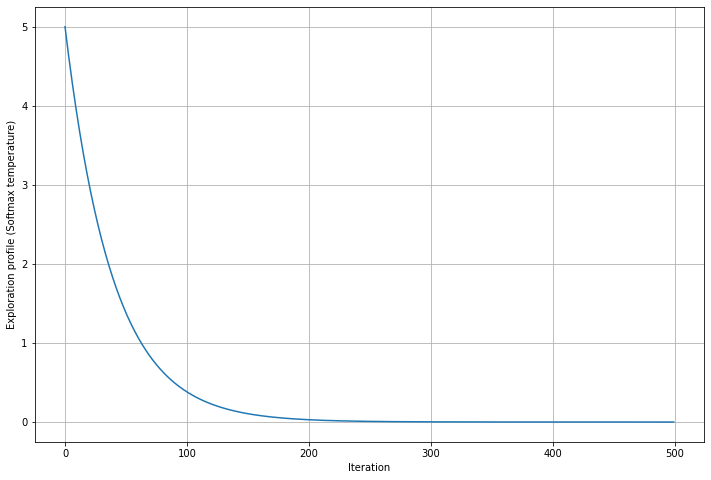

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 500
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 8) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

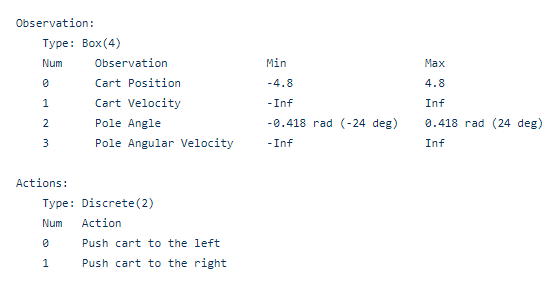

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 20.0
EPISODE 2 - FINAL SCORE: 22.0
EPISODE 3 - FINAL SCORE: 36.0
EPISODE 4 - FINAL SCORE: 15.0
EPISODE 5 - FINAL SCORE: 11.0
EPISODE 6 - FINAL SCORE: 26.0
EPISODE 7 - FINAL SCORE: 37.0
EPISODE 8 - FINAL SCORE: 28.0
EPISODE 9 - FINAL SCORE: 18.0
EPISODE 10 - FINAL SCORE: 17.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()

# Network update

## Initialization

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
PER = False
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
PER_memory_capacity = 10000   # PER memory capacity
lr = 1e-3  # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128  # Number of samples to take from the replay memory for each update
bad_state_penalty = -50   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)   

### Initialize the PER memory
MEMORY = Memory(PER_memory_capacity)    


### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
def update_step(policy_net, target_net, memory, gamma, optimizer, loss_fn, batch_size, PER=False, double=False):
        
    # Sample the data from the memory
    if PER == True:
      tree_idx, batch  = memory.sample(batch_size)
    else:
      batch = memory.sample(batch_size)
      batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)

    if double == True:
      with torch.no_grad():
        policy_net.eval()
        q_values_next = policy_net(non_final_next_states)
        
      # Select the proper Q value for the corresponding action taken Q(s_t, a)
      state_action_values = q_values.gather(1, actions.unsqueeze(1))

      # Use policy network for selecting the action to take
      index = q_values_next.max(dim=1)[1]

      # Compute the value function of the next states using the target network V(s_{t+1}) = ( Q_target(s_{t+1}, arg max_a Q_policy(s_{t+1},a)) )
      with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
      next_state_max_q_values = torch.zeros(batch_size).unsqueeze(1)
      next_state_max_q_values[non_final_mask] = q_values_target.gather(1,index.unsqueeze(1))
    
      # Compute the expected Q values
      expected_state_action_values = rewards.unsqueeze(1) + (next_state_max_q_values * gamma)


    else:
      # Select the proper Q value for the corresponding action taken Q(s_t, a)
      state_action_values = q_values.gather(1, actions.unsqueeze(1))

      # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
      with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states).cpu()
      next_state_max_q_values = torch.zeros(batch_size)
      next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    
      # Compute the expected Q values
      expected_state_action_values = rewards + (next_state_max_q_values * gamma)
      expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

   
    if PER == True:
        absolute_errors = (torch.abs(state_action_values-next_state_max_q_values.unsqueeze(dim=1))).detach()   
        # Update priority
        memory.batch_update(tree_idx, absolute_errors.cpu())

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Reward function

In [ ]:
def reward_fun(next_state,reward):
  if np.abs(next_state[0])>1:
    if next_state[0]*next_state[2]>0:
      if abs(next_state[2])>1:
        reward = reward -2*(np.abs(next_state[0])-1)
  else:
    reward = reward - np.abs(next_state[1])
  return reward



## Training loop

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 50 == 0) # Save a video every 50 episodes

results = []
mean_results = [] 

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      
      # We apply a penalty when the cart is far from center
      pos_weight = 1
      #reward = reward - pos_weight * np.abs(next_state[0])
      reward= reward_fun(next_state,reward)     

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      if PER == True:
        # Update the PER memory
        MEMORY.store((state, action, next_state , reward))
        # Update the network
        update_step(policy_net, target_net, MEMORY, gamma, optimizer, loss_fn, batch_size,PER=True)
      else:
        # Update the replay memory
        replay_mem.push(state, action, next_state , reward)
        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size,double=False)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state
      


    # Save the results
    results.append(score)
    mean_results.append(sum(results[-50:])/min(len(results),50))

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 17 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 11 - Temperature: 4.872888614111293
EPISODE: 3 - FINAL SCORE: 17 - Temperature: 4.749008689107096
EPISODE: 4 - FINAL SCORE: 23 - Temperature: 4.628278073893113
EPISODE: 5 - FINAL SCORE: 48 - Temperature: 4.510616705842939
EPISODE: 6 - FINAL SCORE: 13 - Temperature: 4.395946557704449
EPISODE: 7 - FINAL SCORE: 17 - Temperature: 4.2841915858559485
EPISODE: 8 - FINAL SCORE: 30 - Temperature: 4.175277679877772
EPISODE: 9 - FINAL SCORE: 21 - Temperature: 4.069132613405882
EPISODE: 10 - FINAL SCORE: 29 - Temperature: 3.9656859962348907
Updating target network...
EPISODE: 11 - FINAL SCORE: 16 - Temperature: 3.86486922763872
EPISODE: 12 - FINAL SCORE: 21 - Temperature: 3.766615450877965
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 3.670859508863782
EPISODE: 14 - FINAL SCORE: 36 - Temperature: 3.5775379009488995
EPISODE: 15 - FINAL SCORE: 37 - Temperature: 3.4865887408171012
EPISODE: 16 - FINAL S

In [ ]:
# Display the videos, not required outside Colab
show_videos()

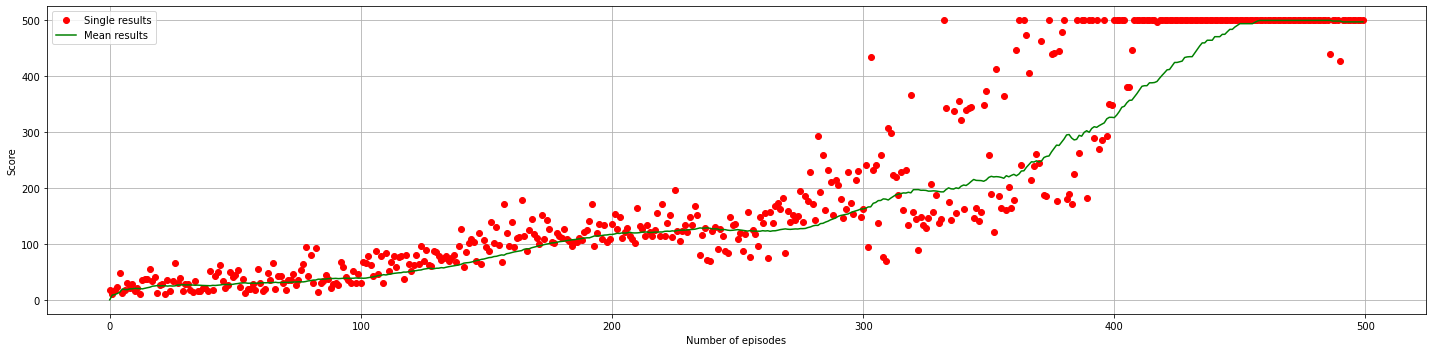

In [ ]:

fig = plt.figure(figsize=(20,5))
plt.plot(range(len(results)),results, marker="o", color="red", linestyle="", label='Single results')
plt.plot(mean_results, color="green",label='Mean results')
plt.xlabel("Number of episodes")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()

Test with initial perturbation

In [ ]:
    env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
 
    # Reset the environment and get the initial state
    state = env.reset()
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(1)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(0)
    state, reward, done, info = env.step(0)



    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f" FINAL SCORE: {score}") 
env.close()

 FINAL SCORE: 485.0


In [ ]:
show_videos()